In [4]:
!pip3 install pyclustering prettytable

You should consider upgrading via the 'C:\Users\Alessandro\Scripts\python.exe -m pip install --upgrade pip' command.


In [5]:
import os

import pandas as pd
import math
import numpy as np
from matplotlib import pyplot as plt
from numpy import logical_and as land, logical_or as lor
import seaborn as sn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import pdist, squareform
from scipy.stats import mode
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from itertools import combinations
from sklearn.cluster import AgglomerativeClustering
from tqdm import tqdm
from pyclustering.cluster.xmeans import xmeans
from pyclustering.cluster import cluster_visualizer
from utilities import *
from sklearn.decomposition import PCA
from utilities import heatmap
from clusteringUtilities import *

In [6]:
DATA_PATH = get_path()

In [7]:
df_indicators = pd.read_csv(DATA_PATH + 'indicators_clean.csv', sep='#')
df_users = pd.read_csv(DATA_PATH + 'users_clean.csv', sep='#')

In [8]:
df_indicators.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140543 entries, 0 to 140542
Data columns (total 34 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   user_id                           140543 non-null  object 
 1   n_tweets                          140543 non-null  int64  
 2   2012_tweets                       140543 non-null  int64  
 3   2013_tweets                       140543 non-null  int64  
 4   2014_tweets                       140543 non-null  int64  
 5   2015_tweets                       140543 non-null  int64  
 6   2016_tweets                       140543 non-null  int64  
 7   2017_tweets                       140543 non-null  int64  
 8   2018_tweets                       140543 non-null  int64  
 9   2019_tweets                       140543 non-null  int64  
 10  2020_tweets                       140543 non-null  int64  
 11  mean_length                       140543 non-null  f

In [9]:
df_users.id = df_users.id.astype(str)
df_merge = df_users.merge(df_indicators, left_on='id', right_on='user_id', how='left')

In [10]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11508 entries, 0 to 11507
Data columns (total 41 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                11508 non-null  object 
 1   name                              11507 non-null  object 
 2   lang                              11508 non-null  object 
 3   bot                               11508 non-null  int64  
 4   user_subscription                 11508 non-null  object 
 5   statuses_count                    11508 non-null  float64
 6   user_subscription_in_secs         11508 non-null  int64  
 7   user_id                           11504 non-null  object 
 8   n_tweets                          11504 non-null  float64
 9   2012_tweets                       11504 non-null  float64
 10  2013_tweets                       11504 non-null  float64
 11  2014_tweets                       11504 non-null  float64
 12  2015

Drop categorical columns

In [11]:
non_numeric_attributes = ['id', 'user_id', 'name', 'lang', 'user_subscription', 'bot']
numeric_attributes = [attr for attr in df_merge.columns if attr not in non_numeric_attributes]
date_attributes = ['user_subscription_in_secs','publication_date_in_secs_mean','publication_date_in_secs_std']
#df_merge.drop(columns=[str(y)+'_tweets' for y in range(2012,2021)], inplace=True)

We try to understand which attributes should be transformed in log scale by analyzing the boxplots

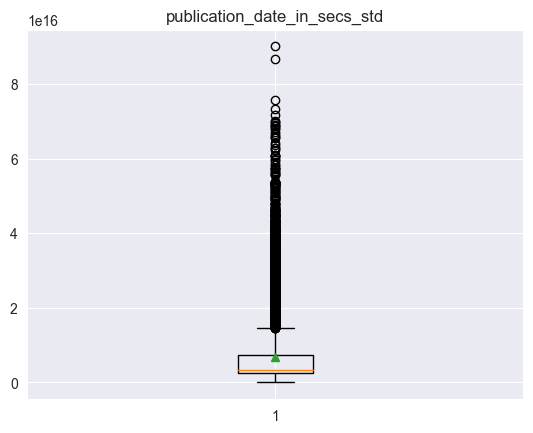

In [12]:
plot_boxplot(df_merge, 'publication_date_in_secs_std')

<AxesSubplot: >

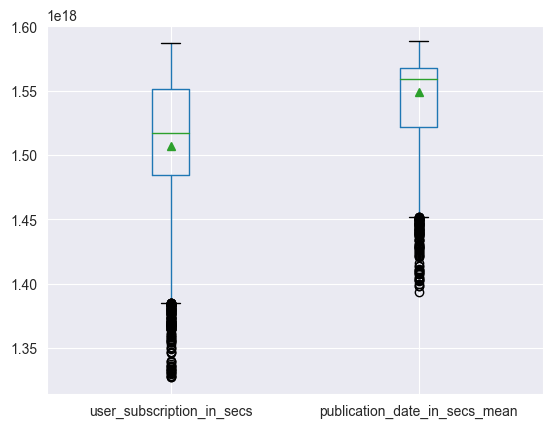

In [13]:
df_merge[['user_subscription_in_secs','publication_date_in_secs_mean']].boxplot(showmeans=True)

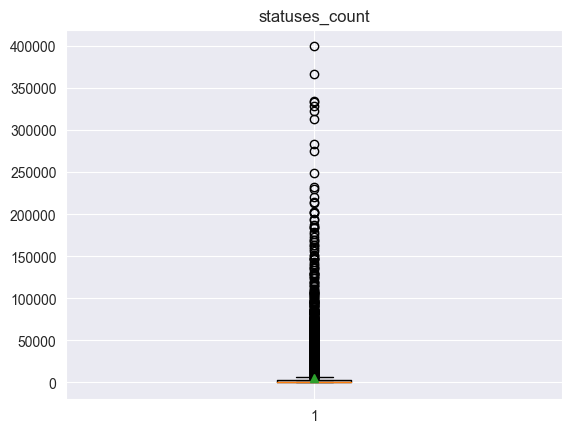

In [14]:
plot_boxplot(df_merge, 'statuses_count')

<AxesSubplot: >

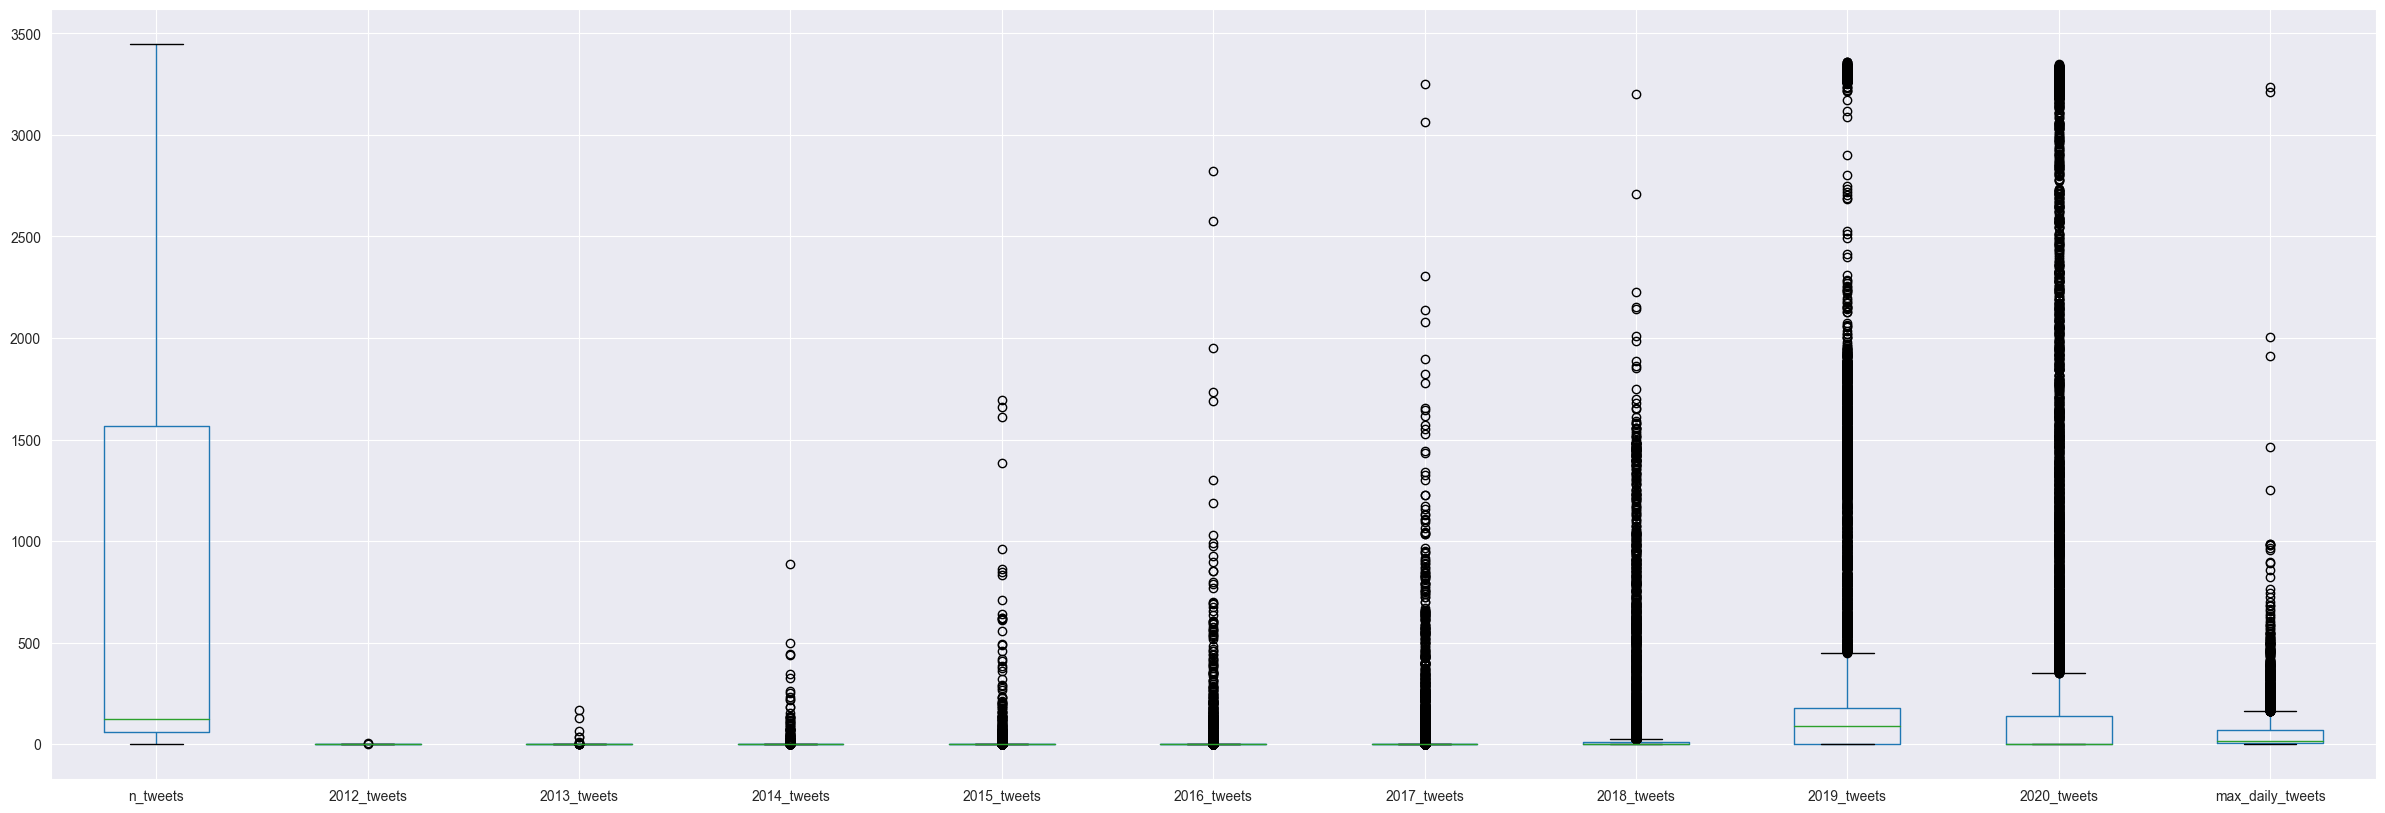

In [15]:
n_tweets_attrs = [attr for attr in df_merge.columns if '_tweets' in attr and 'density' not in attr]
plt.figure(figsize=(30, 10))
df_merge.boxplot(n_tweets_attrs)

<AxesSubplot: >

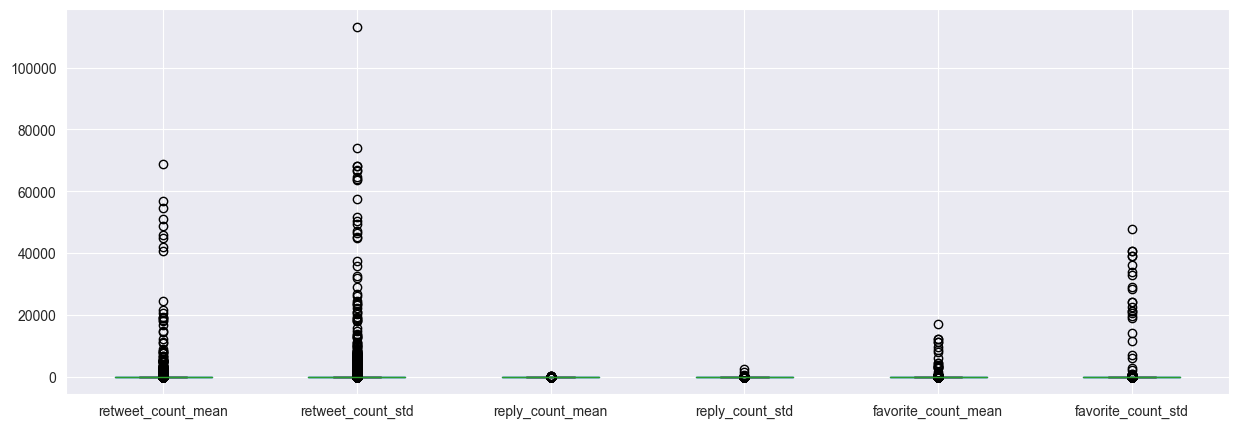

In [16]:
mean_count_attrs = [attr for attr in df_merge.columns if 'count_mean' in attr or  'count_std' in attr]
plt.figure(figsize=(15, 5))
df_merge.boxplot(mean_count_attrs)

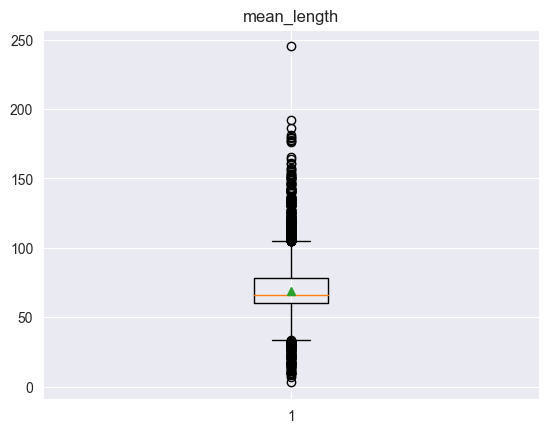

In [17]:
plot_boxplot(df_merge, 'mean_length')

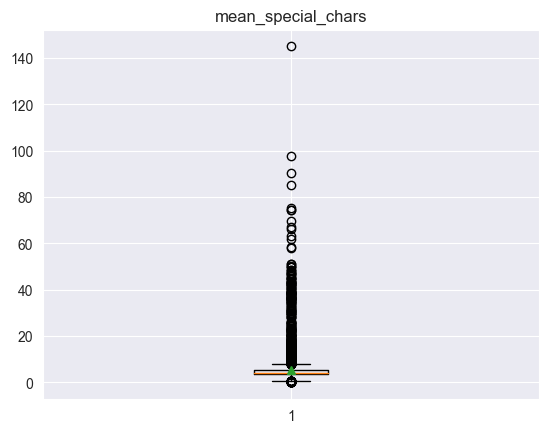

In [18]:
plot_boxplot(df_merge, 'mean_special_chars')

<AxesSubplot: >

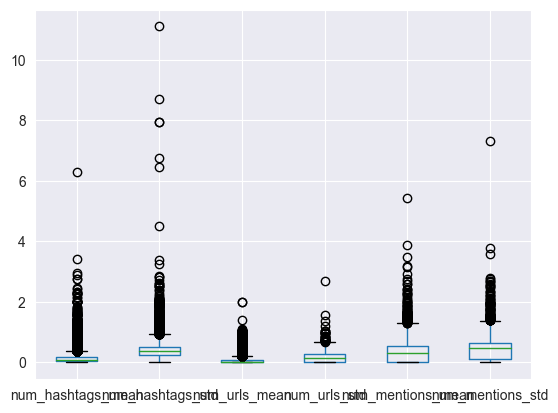

In [19]:
tweet_stats_attributes = ['num_hashtags_mean','num_hashtags_std','num_urls_mean','num_urls_std','num_mentions_mean','num_mentions_std']
df_merge.boxplot(tweet_stats_attributes)

C:\Users\Alessandro\lib\site-packages\numpy\lib\function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


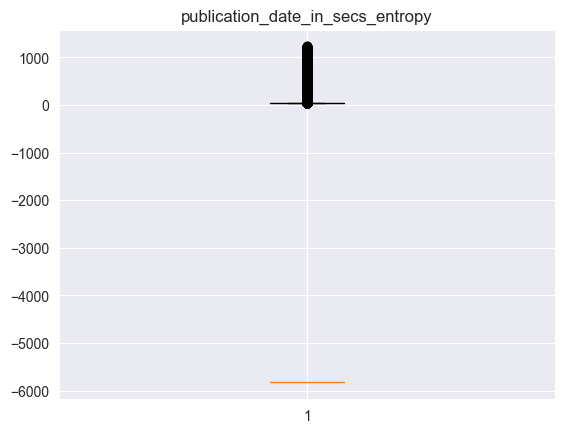

In [20]:
plot_boxplot(df_merge, 'publication_date_in_secs_entropy')

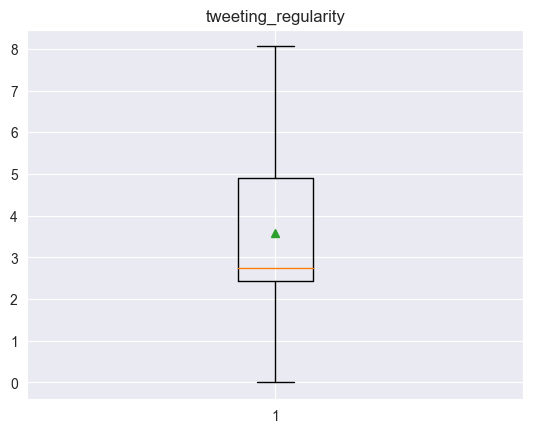

In [21]:
plot_boxplot(df_merge, 'tweeting_regularity')

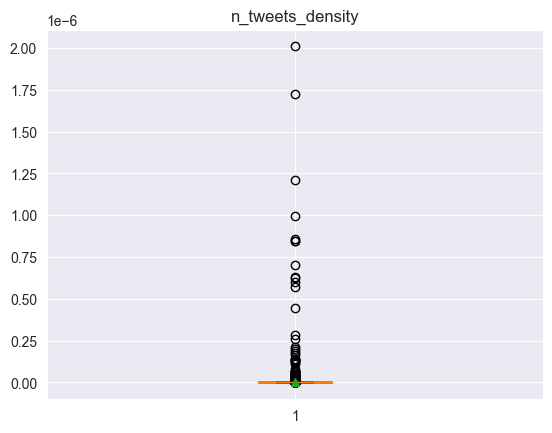

In [22]:
plot_boxplot(df_merge, 'n_tweets_density')

<AxesSubplot: >

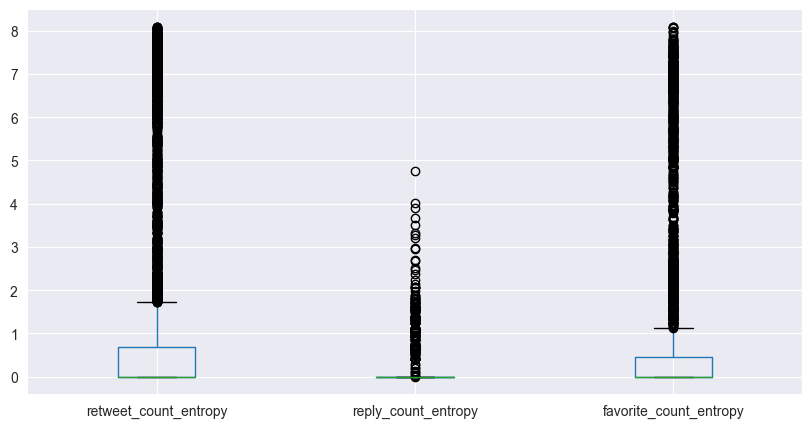

In [23]:
# plot of all the attributes not plotted above, to be sure of not forgetting anything
plt.figure(figsize=(10, 5))
df_merge.boxplot([attr for attr in df_merge.columns if attr not in date_attributes+non_numeric_attributes+['statuses_count','n_tweets','mean_length','tweeting_regularity','publication_date_in_secs_entropy','n_tweets_density','mean_special_chars']+n_tweets_attrs+mean_count_attrs+tweet_stats_attributes])

In [24]:
# To understand which attribute should be transformed in log scale
not_log = ['publication_date_in_secs_mean','user_subscription_in_secs', 'mean_length','tweeting_regularity','retweet_count_entropy','reply_count_entropy','favorite_count_entropy']
attrs_to_log = [c for c in df_merge.columns if c not in not_log+non_numeric_attributes]

In [25]:
# Select values to log
df_merge_log = df_merge[attrs_to_log]

# Replace NaN values in variance with 0
# (NaN values are given when the user only has one tweet so it is safe to assume variance can be 0)
df_merge_log = df_merge_log.fillna(value=0)

# Normalization of values

In [26]:
def to_log(df, attr):
    df[attr] = np.log(df[attr].values)
    df[attr] = df[attr].replace(-np.inf, 0)
    df[attr] = df[attr].fillna(value=0)
    return df[attr]

In [27]:
for attr in attrs_to_log:
    df_merge_log[attr] = to_log(df_merge_log, attr)

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_9480\1059147254.py:2: RuntimeWarning: divide by zero encountered in log
  df[attr] = np.log(df[attr].values)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_9480\1059147254.py:2: RuntimeWarning: invalid value encountered in log
  df[attr] = np.log(df[attr].values)


It is possible to see that our data has very different ranges of values for different attributes going from ranges from 0 to hundreds and from 0 to hundred thousands. This means that it would be best to normalize the values either in a range [0, 1] or in logscale.

In [28]:
from prettytable import PrettyTable

table = PrettyTable(field_names=['attr', 'min', 'max'])
for attr in df_merge_log.columns:
    table.add_row([attr, df_merge_log[attr].min(), df_merge_log[attr].max()])
print(table)

+----------------------------------+---------------------+--------------------+
|               attr               |         min         |        max         |
+----------------------------------+---------------------+--------------------+
|          statuses_count          |         0.0         | 12.898106706802647 |
|             n_tweets             |         0.0         | 8.145259566516865  |
|           2012_tweets            |         0.0         | 1.9459101490553132 |
|           2013_tweets            |         0.0         | 5.1298987149230735 |
|           2014_tweets            |         0.0         | 6.785587645007929  |
|           2015_tweets            |         0.0         | 7.436617265234227  |
|           2016_tweets            |         0.0         | 7.945909598613133  |
|           2017_tweets            |         0.0         | 8.086410275323782  |
|           2018_tweets            |         0.0         |  8.07153089355666  |
|           2019_tweets            |    

In [29]:
# Normalizzare i valori in log
df_merge_log[not_log] = df_merge[not_log]
scaler = MinMaxScaler()
scaler.fit(df_merge_log.values)
df_merge_scaled = scaler.transform(df_merge_log.values)
df_merge_scaled = pd.DataFrame(df_merge_scaled, columns=df_merge_log.columns)

In [30]:
from prettytable import PrettyTable

table = PrettyTable(field_names=['attr', 'min', 'max'])
for attr in df_merge_scaled.columns:
    table.add_row([attr, df_merge_scaled[attr].min(), df_merge_scaled[attr].max()])
print(table)

+----------------------------------+-----+--------------------+
|               attr               | min |        max         |
+----------------------------------+-----+--------------------+
|          statuses_count          | 0.0 |        1.0         |
|             n_tweets             | 0.0 |        1.0         |
|           2012_tweets            | 0.0 |        1.0         |
|           2013_tweets            | 0.0 |        1.0         |
|           2014_tweets            | 0.0 | 0.9999999999999999 |
|           2015_tweets            | 0.0 | 0.9999999999999999 |
|           2016_tweets            | 0.0 |        1.0         |
|           2017_tweets            | 0.0 |        1.0         |
|           2018_tweets            | 0.0 |        1.0         |
|           2019_tweets            | 0.0 |        1.0         |
|           2020_tweets            | 0.0 |        1.0         |
|   publication_date_in_secs_std   | 0.0 |        1.0         |
| publication_date_in_secs_entropy | 0.0

In [31]:
df_merge_scaled[non_numeric_attributes] = df_merge[non_numeric_attributes]

In [32]:
df_merge_scaled.fillna(0, inplace=True)

In [33]:
df_merge[numeric_attributes].fillna(0).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11508 entries, 0 to 11507
Data columns (total 35 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   statuses_count                    11508 non-null  float64
 1   user_subscription_in_secs         11508 non-null  int64  
 2   n_tweets                          11508 non-null  float64
 3   2012_tweets                       11508 non-null  float64
 4   2013_tweets                       11508 non-null  float64
 5   2014_tweets                       11508 non-null  float64
 6   2015_tweets                       11508 non-null  float64
 7   2016_tweets                       11508 non-null  float64
 8   2017_tweets                       11508 non-null  float64
 9   2018_tweets                       11508 non-null  float64
 10  2019_tweets                       11508 non-null  float64
 11  2020_tweets                       11508 non-null  float64
 12  mean

# PCA

In [34]:
df_merge_scaled[['pc1','pc2']] = PCA(n_components=2).fit_transform(df_merge_scaled[numeric_attributes])
df_merge_scaled[['pc1','pc2','bot']]

,pc1,pc2,bot
0,-0.283977,-0.363982,1
1,-0.272627,-0.408293,0
2,-0.953464,0.346542,1
3,0.120104,-0.589019,1
4,0.883198,0.633786,0
...,...,...,...
11503,0.592998,0.500017,0
11504,0.743069,-0.022395,0
11505,-0.800429,0.309681,0
11506,-0.326335,-0.358324,1


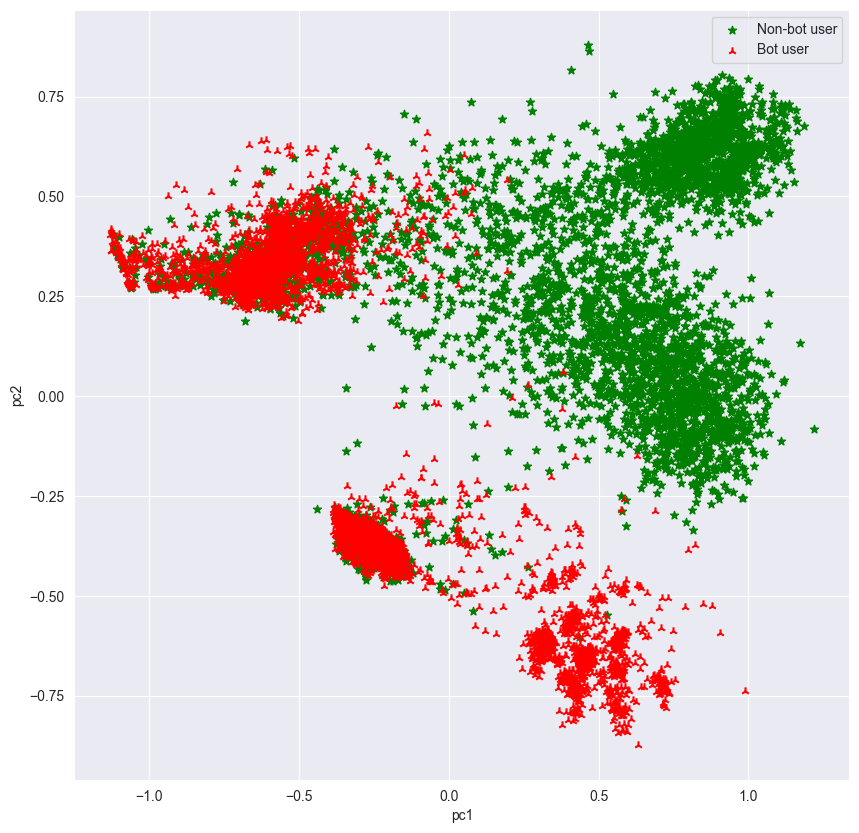

In [35]:
plt.figure(figsize=(10,10))
bot_scatter(df_merge_scaled,'pc1','pc2',path="bot_pca.png")

In [36]:
df_merge_scaled.to_csv(path_or_buf=DATA_PATH+'data_scaled_for_clustering.csv', sep='#', index=False)